In [ ]:
"""
b站：https://www.bilibili.com/video/BV1bt421578n?spm_id_from=333.788.videopod.sections&vd_source=e4234f5ddbe45b813cf4296e06e14b9b&p=3
DeepLearning.AI课程: https://learn.deeplearning.ai/courses/efficiently-serving-llms/lesson/etx7v/lorax
"""

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [4]:
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

/home/pengfan/.local/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## KV cache

In [ ]:
prompt = "The quick brown fox jumped over the"
inputs = tokenizer(prompt, return_tensors="pt")
print(inputs)

def generate_token_with_past(inputs):
    with torch.no_grad(): # 不计算梯度
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values


def generate(inputs, max_tokens):
    generated_tokens = []
    next_inputs = inputs
    for _ in range(max_tokens):
        next_token_id, past_key_values = \
        generate_token_with_past(next_inputs)
        next_inputs = {
            "input_ids": next_token_id.reshape((1, 1)), # 只传入下一个token的id
            "attention_mask": torch.cat(
                [next_inputs["attention_mask"], torch.tensor([[1]])],
                dim=1
            ),
            "past_key_values": past_key_values,
        }

        next_token = tokenizer.decode(next_token_id)
        generated_tokens.append(next_token)
    return "".join(generated_tokens)


tokens = generate(inputs, max_tokens=10)
print(tokens)

{'input_ids': tensor([[  464,  2068,  7586, 21831, 11687,   625,   262]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}
 fence and ran to the other side of the fence


## Batch decode

In [23]:
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id
# pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

In [48]:
prompts = [
    "The quick brown fox jumped over the",
    "The rain in Spain falls",
    "What comes up must",
]
inputs = tokenizer(prompts, padding=True, return_tensors="pt")

In [32]:
def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values

In [39]:
def generate_batch(inputs, max_tokens):
    # 给定bs大小的空列表，存储输出
    generated_tokens = [
        [] for _ in range(inputs["input_ids"].shape[0])
    ]

    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)

    next_inputs = {
        "position_ids": position_ids,
        **inputs
    }

    for _ in range(max_tokens):
        next_token_ids, past_key_values = \
            generate_batch_tokens_with_past(next_inputs)
        # print("next_position_ids:", next_inputs["position_ids"])
        # print("position_ids:", next_inputs["position_ids"][:, -1].unsqueeze(-1) + 1)
        next_inputs = {
            "input_ids": next_token_ids.reshape((-1, 1)), # 只传入下一个token的id
            "position_ids": next_inputs["position_ids"][:, -1].unsqueeze(-1) + 1, # 只传入下一个token的位置
            "attention_mask": torch.cat([
                next_inputs["attention_mask"],
                torch.ones((next_token_ids.shape[0], 1)),
            ], dim=1),
            "past_key_values": past_key_values,
        }

        next_tokens = tokenizer.batch_decode(next_token_ids)
        for i, token in enumerate(next_tokens):
            generated_tokens[i].append(token)
    return ["".join(tokens) for tokens in generated_tokens]

In [42]:
generated_tokens = generate_batch(inputs, max_tokens=10)

In [43]:
for prompt, generated in zip(prompts, generated_tokens):
    print(prompt, f"\x1b[31m{generated}\x1b[0m\n") # 红色字体显示生成的文本

The quick brown fox jumped over the  fence and ran to the other side of the fence

The rain in Spain falls  on the first day of the month, and the

What comes up must  be a good idea.

"I think



## 吞吐量与延迟
- 探索批处理对延迟的影响（生成每个令牌需要多长时间）。 
- 观察吞吐量和延迟之间存在的基本权衡。

In [45]:
# constants
max_tokens = 10

# observations
durations = []
throughputs = []
latencies = []

batch_sizes = [2**p for p in range(8)] # [1, 2, 4, 8, 16, 32, 64, 128]
for batch_size in batch_sizes:
    print(f"bs= {batch_size}")

    # 记录不同batch size下的生成时间和吞吐量
    t0 = time.time()
    batch_prompts = [
        prompts[i % len(prompts)] for i in range(batch_size) # 重复使用prompts
    ]
    inputs = tokenizer(
        batch_prompts, padding=True, return_tensors="pt"
    )
    generated_tokens = generate_batch(inputs, max_tokens=max_tokens)
    duration_s = time.time() - t0

    ntokens = batch_size * max_tokens
    throughput = ntokens / duration_s
    avg_latency = duration_s / max_tokens
    print("duration", duration_s)
    print("throughput", throughput)
    print("avg latency", avg_latency)    
    print()

    durations.append(duration_s)
    throughputs.append(throughput)
    latencies.append(avg_latency)

bs= 1
duration 0.6177549362182617
throughput 16.18764887775313
avg latency 0.061775493621826175

bs= 2
duration 0.9665660858154297
throughput 20.691808137595977
avg latency 0.09665660858154297

bs= 4
duration 0.851855993270874
throughput 46.95629345332405
avg latency 0.0851855993270874

bs= 8
duration 1.0085225105285645
throughput 79.32396070968429
avg latency 0.10085225105285645

bs= 16
duration 1.458956241607666
throughput 109.66744268059156
avg latency 0.1458956241607666

bs= 32
duration 1.9382057189941406
throughput 165.10115353806125
avg latency 0.19382057189941407

bs= 64
duration 3.983337640762329
throughput 160.66928232514007
avg latency 0.3983337640762329

bs= 128
duration 7.6774022579193115
throughput 166.72306035282548
avg latency 0.7677402257919311



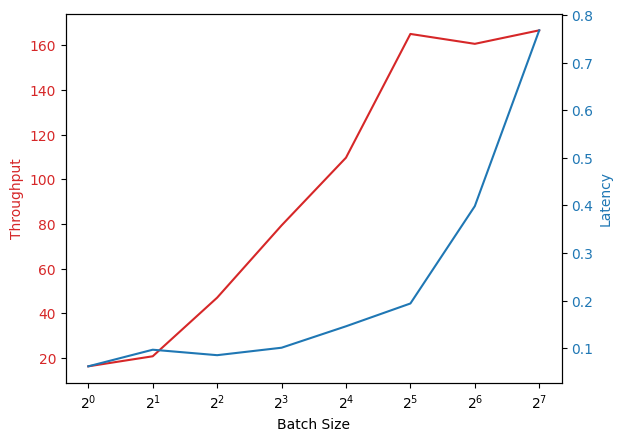

In [46]:
def render_plot(x, y1, y2, x_label, y1_label, y2_label):
    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots()

    # Plot the first line (throughput)
    color = 'tab:red'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Set the x-axis to be log-scaled
    ax1.set_xscale('log', base=2)

    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

render_plot(
    batch_sizes,
    throughputs,
    latencies,
    "Batch Size",
    "Throughput",
    "Latency"
)

## Continuous Batching

In [50]:
prompts = [
    "The quick brown fox jumped over the",
    "The rain in Spain falls",
    "What comes up must",
]

# note: padding=True ensures the padding token will be inserted into the tokenized tensors
inputs = tokenizer(prompts, padding=True, return_tensors="pt")

In [55]:
import random
# seed the random number generator so our results are deterministic
random.seed(42)

# constants
queue_size = 32
batch_size = 8

# requests waiting to be processed
# requests are tuples (prompt, max_tokens)
request_queue = [
    (prompts[0], 100 if i % batch_size == 0 else 10)
    for i in range(queue_size)
] # 模拟32个队列请求

In [56]:
request_queue[:8]

[('The quick brown fox jumped over the', 100),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10)]

In [58]:
# 将请求队列分成批次
batches = [
    request_queue[i: i + batch_size]
    for i in range(0, len(request_queue), batch_size)
]

In [62]:
len(batches)

4

In [60]:
from tqdm import tqdm
# generate tokens for all batches and record duration
t0 = time.time()
with tqdm(total=len(batches), desc=f"bs={batch_size}") as pbar:
    for i, batch in enumerate(batches):
        # to accommodate all the requests with our 
        # current implementation, we take the max of
        # all the tokens to generate among the requests
        batch_max_tokens = [b[1] for b in batch]
        max_tokens = max(batch_max_tokens)
        pbar.set_postfix({'max_tokens': max_tokens})
        
        batch_prompts = [b[0] for b in batch]
        inputs = tokenizer(
            batch_prompts, padding=True, return_tensors="pt")
        generate_batch(inputs, max_tokens=max_tokens)
        
        pbar.update(1)

duration_s = time.time() - t0
print("duration", duration_s)

bs=8: 100%|██████████| 4/4 [00:40<00:00, 10.21s/it, max_tokens=100]

duration 41.478201389312744


In [64]:
import copy
import torch.nn.functional as F

def init_batch(requests):
    prompts = [r[0] for r in requests]
    inputs = tokenizer(prompts, padding=True, return_tensors="pt")

    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)

    return {
        "position_ids": position_ids,
        "responses": copy.copy(prompts),
        "tokens_remaining": [r[1] for r in requests],
        **inputs
    }

def generate_next_token(batch):
    inputs = copy.copy(batch)
    inputs.pop("responses")
    inputs.pop("tokens_remaining")

    next_token_ids, past_key_values = generate_batch_tokens_with_past(inputs)
    next_tokens = tokenizer.batch_decode(next_token_ids)

    return get_next_inputs(
        batch,
        next_token_ids,
        past_key_values,
        next_tokens
    )

def get_next_inputs(batch, next_token_ids, past_key_values, next_tokens):
    return {
        # '-1' here means the remaining elements for this dim
        "input_ids": next_token_ids.reshape((-1, 1)),

        # increment last, discard the rest
        "position_ids": batch["position_ids"][:, -1].unsqueeze(-1) + 1,

        # concatenate vector of 1's with shape [batch_size, 1]
        "attention_mask": torch.cat([
            batch["attention_mask"],
            torch.ones((next_token_ids.shape[0], 1)),
        ], dim=1),

        "past_key_values": past_key_values,

        "responses": [
            r1 + r2 for r1, r2 in zip(batch["responses"], next_tokens)
        ],

        "tokens_remaining": [
            v - 1 for v in batch["tokens_remaining"]
        ],
    }

def merge_batches(batch1, batch2):
    # === 1. 计算 attention_mask 的最大长度 ===
    attn_mask1 = batch1["attention_mask"]
    attn_mask2 = batch2["attention_mask"]
    max_seq_len = max(attn_mask1.shape[1], attn_mask2.shape[1])

    # === 2. 左侧 padding 到最大长度（填 0）===
    padding1 = max_seq_len - attn_mask1.shape[1]
    padding2 = max_seq_len - attn_mask2.shape[1]

    attn_mask1 = F.pad(attn_mask1, (padding1, 0), "constant", 0)
    attn_mask2 = F.pad(attn_mask2, (padding2, 0), "constant", 0)

    # === 3. pad past_key_values（[B, H, S, D]）===
    past_kv1 = batch1["past_key_values"]
    past_kv2 = batch2["past_key_values"]

    padded_kv1 = []
    for k, v in past_kv1:
        k = F.pad(k, (0, 0, padding1, 0), "constant", 0)
        v = F.pad(v, (0, 0, padding1, 0), "constant", 0)
        padded_kv1.append((k, v))

    padded_kv2 = []
    for k, v in past_kv2:
        k = F.pad(k, (0, 0, padding2, 0), "constant", 0)
        v = F.pad(v, (0, 0, padding2, 0), "constant", 0)
        padded_kv2.append((k, v))

    # === 4. 合并 input_ids、position_ids、attention_mask ===
    input_ids = torch.concat([batch1["input_ids"], batch2["input_ids"]], dim=0)
    position_ids = torch.concat([batch1["position_ids"], batch2["position_ids"]], dim=0)
    attn_mask = torch.concat([attn_mask1, attn_mask2], dim=0)

    # === 5. 合并 past_key_values（按层拼 batch 维）===
    past_kv = []
    for (k1, v1), (k2, v2) in zip(padded_kv1, padded_kv2):
        k = torch.concat([k1, k2], dim=0)
        v = torch.concat([v1, v2], dim=0)
        past_kv.append((k, v))

    # === 6. 合并其他字段（responses, tokens_remaining）===
    return {
        "input_ids": input_ids,
        "position_ids": position_ids,
        "attention_mask": attn_mask,
        "past_key_values": past_kv,
        "responses": batch1["responses"] + batch2["responses"],
        "tokens_remaining": batch1["tokens_remaining"] + batch2["tokens_remaining"],
    }

def filter_batch(batch):
    # === 1. 找出 tokens_remaining <= 0 的样本索引 ===
    remove_indices = []
    for i, tokens_remaining in enumerate(batch["tokens_remaining"]):
        if tokens_remaining <= 0:
            remove_indices.append(i)

    # === 2. 构建布尔掩码，True 表示保留该样本 ===
    batch_size = batch["input_ids"].size(0)
    mask = torch.ones(batch_size, dtype=torch.bool)
    mask[remove_indices] = False

    # === 3. 根据掩码过滤 tensor 类型的数据 ===
    input_ids = batch["input_ids"][mask]
    position_ids = batch["position_ids"][mask]
    attention_mask = batch["attention_mask"][mask]

    # === 4. 过滤 list 类型的数据 ===
    responses = [
        r for i, r in enumerate(batch["responses"]) if i not in remove_indices
    ]
    tokens_remaining = [
        v for i, v in enumerate(batch["tokens_remaining"]) if i not in remove_indices
    ]

    # === 5. 过滤 past_key_values 中的样本 ===
    past_key_values = batch["past_key_values"]
    new_past_key_values = []
    for k, v in past_key_values:
        k = k[mask]
        v = v[mask]
        new_past_key_values.append((k, v))
    past_key_values = new_past_key_values

    # === 6. 可选优化：左截断 padding，节省计算 ===
    if input_ids.size(0) > 0:
        # 找出每行 attention_mask 中开头 0（padding）的数量
        zero_mask = attention_mask == 0
        cumprod = zero_mask.cumprod(dim=1)  # 在遇到 1 后停止累乘
        leading_zeros_count = cumprod.sum(dim=1)
        min_leading_zeros = torch.min(leading_zeros_count)
        truncation_offset = min_leading_zeros.item()

        # 截断 attention_mask
        attention_mask = attention_mask[:, truncation_offset:]

        # 截断 past_key_values 中的 sequence_length 维度
        new_past_key_values = []
        for k, v in past_key_values:
            k = k[:, :, truncation_offset:, :]
            v = v[:, :, truncation_offset:, :]
            new_past_key_values.append((k, v))
        past_key_values = new_past_key_values

    # === 7. 返回过滤后的 batch 和被移除的索引列表 ===
    return {
        "input_ids": input_ids,
        "position_ids": position_ids,
        "attention_mask": attention_mask,
        "past_key_values": past_key_values,
        "responses": responses,
        "tokens_remaining": tokens_remaining,
    }, remove_indices




# seed the random number generator so our results are deterministic
random.seed(42)

# constants
queue_size = 32
batch_size = 8

# requests waiting to be processed
# this time requests are tuples (prompt, max_tokens)
request_queue = [
    (prompts[0], 100 if i % batch_size == 0 else 10)
    for i in range(queue_size)
]

t0 = time.time()
with tqdm(total=len(request_queue), desc=f"bs={batch_size}") as pbar:
    # first, let's seed the initial cached_batch
    # with the first `batch_size` inputs
    # and run the initial prefill step
    batch = init_batch(request_queue[:batch_size])
    cached_batch = generate_next_token(batch)
    request_queue = request_queue[batch_size:]

    # continue until both the request queue is 
    # fully drained and every input
    # within the cached_batch has completed generation
    while (
        len(request_queue) > 0 or
        cached_batch["input_ids"].size(0) > 0
    ):
        batch_capacity = (
            batch_size - cached_batch["input_ids"].size(0)
        )
        if batch_capacity > 0 and len(request_queue) > 0:
            # prefill
            new_batch = init_batch(request_queue[:batch_capacity])
            new_batch = generate_next_token(new_batch)
            request_queue = request_queue[batch_capacity:]

            # merge
            cached_batch = merge_batches(cached_batch, new_batch)

        # decode
        cached_batch = generate_next_token(cached_batch)

        # remove any inputs that have finished generation
        cached_batch, removed_indices = filter_batch(cached_batch)
        pbar.update(len(removed_indices))

duration_s = time.time() - t0
print("duration", duration_s)

bs=8: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]

duration 13.968080759048462


## Quantization

In [65]:
from transformers.models.gpt2.modeling_gpt2 import GPT2Model
# fix dtype post quantization to "pretend" to be fp32
def get_float32_dtype(self):
    return torch.float32
GPT2Model.dtype = property(get_float32_dtype)

In [66]:
model.get_memory_footprint()

510342192

In [67]:
def quantize(t):
    # obtain range of values in the tensor to map between 0 and 255
    min_val, max_val = t.min(), t.max()

    # determine the "zero-point", or value in the tensor to map to 0
    scale = (max_val - min_val) / 255
    zero_point = min_val

    # quantize and clamp to ensure we're in [0, 255]
    t_quant = (t - zero_point) / scale
    t_quant = torch.clamp(t_quant, min=0, max=255)

    # keep track of scale and zero_point for reversing quantization
    state = (scale, zero_point)

    # cast to uint8 and return
    t_quant = t_quant.type(torch.uint8)
    return t_quant, state

In [68]:
t = model.transformer.h[0].attn.c_attn.weight.data
print(t, t.shape)

tensor([[-0.4738, -0.2614, -0.0978,  ...,  0.0513, -0.0584,  0.0250],
        [ 0.0874,  0.1473,  0.2387,  ..., -0.0525, -0.0113, -0.0156],
        [ 0.0039,  0.0695,  0.3668,  ...,  0.1143,  0.0363, -0.0318],
        ...,
        [-0.2592, -0.0164,  0.1991,  ...,  0.0095, -0.0516,  0.0319],
        [ 0.1517,  0.2170,  0.1043,  ...,  0.0293, -0.0429, -0.0475],
        [-0.4100, -0.1924, -0.2400,  ..., -0.0046,  0.0070,  0.0198]]) torch.Size([768, 2304])


In [72]:
t_q, state = quantize(t) # int8量化
print(t_q, t_q.min(), t_q.max())

tensor([[107, 116, 124,  ..., 130, 125, 129],
        [132, 135, 139,  ..., 126, 128, 127],
        [128, 131, 145,  ..., 133, 130, 127],
        ...,
        [116, 127, 137,  ..., 129, 126, 130],
        [135, 138, 133,  ..., 129, 126, 126],
        [110, 119, 117,  ..., 128, 128, 129]], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


In [73]:
def dequantize(t, state):
    scale, zero_point = state
    return t.to(torch.float32) * scale + zero_point

In [74]:
t_rev = dequantize(t_q, state) # 反量化
print(t_rev)

tensor([[-0.4774, -0.2783, -0.1014,  ...,  0.0313, -0.0793,  0.0092],
        [ 0.0755,  0.1419,  0.2303,  ..., -0.0572, -0.0129, -0.0351],
        [-0.0129,  0.0534,  0.3630,  ...,  0.0976,  0.0313, -0.0351],
        ...,
        [-0.2783, -0.0351,  0.1861,  ...,  0.0092, -0.0572,  0.0313],
        [ 0.1419,  0.2082,  0.0976,  ...,  0.0092, -0.0572, -0.0572],
        [-0.4110, -0.2120, -0.2562,  ..., -0.0129, -0.0129,  0.0092]])


In [75]:
torch.abs(t - t_rev) # 精度损失

tensor([[0.0035, 0.0170, 0.0036,  ..., 0.0200, 0.0209, 0.0158],
        [0.0119, 0.0055, 0.0084,  ..., 0.0046, 0.0017, 0.0195],
        [0.0168, 0.0161, 0.0038,  ..., 0.0167, 0.0050, 0.0032],
        ...,
        [0.0191, 0.0187, 0.0131,  ..., 0.0004, 0.0056, 0.0006],
        [0.0098, 0.0088, 0.0067,  ..., 0.0202, 0.0143, 0.0097],
        [0.0010, 0.0196, 0.0162,  ..., 0.0084, 0.0199, 0.0107]])

In [80]:
inputs = tokenizer("The quick brown fox jumped over the", return_tensors="pt")
print(inputs)
response_expected = generate(
    inputs,
    10
)
response_expected

{'input_ids': tensor([[  464,  2068,  7586, 21831, 11687,   625,   262]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


' fence and ran to the other side of the fence'

In [81]:
# 量化整个模型
def quantize_model(model):
    states = {}
    for name, param in model.named_parameters():
        param.requires_grad = False
        param.data, state = quantize(param.data)
        states[name] = state
    return model, states

In [82]:
quant_model, states = quantize_model(model)

In [83]:
states

{'transformer.wte.weight': (tensor(0.0120), tensor(-1.2698)),
 'transformer.wpe.weight': (tensor(0.0337), tensor(-4.5381)),
 'transformer.h.0.ln_1.weight': (tensor(0.0008), tensor(0.0419)),
 'transformer.h.0.ln_1.bias': (tensor(0.0018), tensor(-0.2589)),
 'transformer.h.0.attn.c_attn.weight': (tensor(0.0221), tensor(-2.8436)),
 'transformer.h.0.attn.c_attn.bias': (tensor(0.0099), tensor(-1.3371)),
 'transformer.h.0.attn.c_proj.weight': (tensor(0.0250), tensor(-3.3171)),
 'transformer.h.0.attn.c_proj.bias': (tensor(0.0185), tensor(-2.6844)),
 'transformer.h.0.ln_2.weight': (tensor(0.0057), tensor(0.0453)),
 'transformer.h.0.ln_2.bias': (tensor(0.0055), tensor(-0.6648)),
 'transformer.h.0.mlp.c_fc.weight': (tensor(0.0271), tensor(-2.3131)),
 'transformer.h.0.mlp.c_fc.bias': (tensor(0.0042), tensor(-0.7462)),
 'transformer.h.0.mlp.c_proj.weight': (tensor(0.0479), tensor(-6.1433)),
 'transformer.h.0.mlp.c_proj.bias': (tensor(0.0098), tensor(-1.0288)),
 'transformer.h.1.ln_1.weight': (tenso

In [84]:
quant_model.get_memory_footprint() # 从0.4GB降到0.1GB

137022768

In [90]:
def size_in_bytes(t): # 计算张量 t 在内存中实际占用了多少字节（bytes）
    return t.numel() * t.element_size()

In [91]:
sum([
    size_in_bytes(v[0]) + size_in_bytes(v[1])
    for v in states.values()
])

1184

In [93]:
# 反量化整个模型
def dequantize_model(model, states):
    for name, param in model.named_parameters():
        state = states[name]
        param.data = dequantize(param.data, state)
    return model

In [94]:
dequant_model = dequantize_model(quant_model, states)

In [95]:
dequant_model.get_memory_footprint()

510342192

## Low-Rank Adaptation

In [96]:
import torch
torch.manual_seed(42)

In [97]:
class TestModel(torch.nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.embedding = torch.nn.Embedding(10, hidden_size)
        self.linear = torch.nn.Linear(hidden_size, hidden_size)
        self.lm_head = torch.nn.Linear(hidden_size, 10)
    
    def forward(self, input_ids):
        x = self.embedding(input_ids)
        x = self.linear(x)
        x = self.lm_head(x)
        return x

In [98]:
# set a reasonably large hidden size to illustrate the small fraction of
# params needed to be added for LoRA
hidden_size = 1024
model = TestModel(hidden_size)

In [99]:
# dummy inputs
input_ids = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7]])

In [100]:
# toy example of a detokenizer. 
# The vocabulary only consists of 10 words (different colors)
detokenizer = [
    "red",
    "orange",
    "yellow",
    "green",
    "blue",
    "indigo",
    "violet",
    "magenta",
    "marigold",
    "chartreuse",
]

In [102]:
def generate_token(model, **kwargs):
    with torch.no_grad():
        logits = model(**kwargs)
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)

    return [detokenizer[token_id] for token_id in next_token_ids]

In [106]:
# generate one token
next_token = generate_token(model, input_ids=input_ids)[0]
next_token

'magenta'

In [107]:
# dummy input tensor
# shape: (batch_size, sequence_length, hidden_size)
X = torch.randn(1, 8, 1024)

In [108]:
# LoRA A and B tensors
# A has shape (hidden_size, rank)
# B has shape (rank, hidden_size)
lora_a = torch.randn(1024, 2)
lora_b = torch.randn(2, 1024)

In [109]:
W = model.linear.weight

In [111]:
W.shape

torch.Size([1024, 1024])

In [112]:
W2 = lora_a @ lora_b

In [113]:
W2.shape

torch.Size([1024, 1024])

In [114]:
# Compare number of elements of A and B with number of elements of W
# W here has shape (hidden_size, hidden_size)
lora_numel = lora_a.numel() + lora_b.numel()
base_numel = W.numel()
print("|A+B| / |W|:", lora_numel / base_numel)

|A+B| / |W|: 0.00390625


In [115]:
# compute the output of X @ W (the original linear layer)
base_output = model.linear(X)

# compute the output of X @ A @ B (the added lora adapter)
lora_output = X @ lora_a @ lora_b

# sum them together
total_output = base_output + lora_output

# output should have the same shape as the original output:
# (batch_size, sequence_length, hidden_size)
total_output.shape

torch.Size([1, 8, 1024])

In [116]:
class LoraLayer(torch.nn.Module):
    def __init__(self, base_layer, r):
        super().__init__()
        self.base_layer = base_layer
        
        d_in, d_out = self.base_layer.weight.shape
        self.lora_a = torch.randn(d_in, r)
        self.lora_b = torch.randn(r, d_out) 
        
    def forward(self, x):
        y1 = self.base_layer(x)
        y2 = x @ self.lora_a @ self.lora_b
        return y1 + y2

In [117]:
# wrap the linear layer of our toy model, use rank 2
lora_layer = LoraLayer(model.linear, 2)
lora_layer(X).shape

torch.Size([1, 8, 1024])

In [118]:
model.linear = lora_layer

In [119]:
model

TestModel(
  (embedding): Embedding(10, 1024)
  (linear): LoraLayer(
    (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (lm_head): Linear(in_features=1024, out_features=10, bias=True)
)

In [120]:
next_token = generate_token(model, input_ids=input_ids)
next_token[0]

'indigo'

## Multi-Lora inference

In [121]:
class AbstractMultiLoraModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # hidden_size = 10
        # set this so low to ensure we are not 
        # compute-bound by the linear layer
        # this is only an issue when running on CPU, 
        # for GPUs we can set this much
        # higher and still avoid being compute bound
        self.embedding = torch.nn.Embedding(10, 10)
        self.linear = torch.nn.Linear(10, 10)
        self.lm_head = torch.nn.Linear(10, 10)

    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, rank)
        loras_b: torch.Tensor,           # (num_loras, rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        # y[i] = x[i] @ loras_a[lora_idx] @ loras_b[lora_idx]
        raise NotImplementedError()

    def forward(self, input_ids, loras_a, loras_b, lora_indices):
        x = self.embedding(input_ids)
        x = self.linear_lora(x, loras_a, loras_b, lora_indices)
        x = self.lm_head(x)
        return x

In [122]:
class LoopMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, lora_rank)
        loras_b: torch.Tensor,           # (num_loras, lora_rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        y = self.linear(x)
        for batch_idx, lora_idx in enumerate(lora_indices.numpy()):
            lora_a = loras_a[lora_idx]
            lora_b = loras_b[lora_idx]
            y[batch_idx] += x[batch_idx] @ lora_a @ lora_b
        return y

In [123]:
# toy example of a detokenizer. The vocabular only consists of 10 words (different colors)
detokenizer = [
    "red",
    "orange",
    "yellow",
    "green",
    "blue",
    "indigo",
    "violet",
    "magenta",
    "marigold",
    "chartreuse",
]

In [124]:
# dummy inputs
input_ids = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7]])
torch.manual_seed(42)
def generate_token(model, **kwargs):
    with torch.no_grad():
        logits = model(**kwargs)
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)

    return [detokenizer[token_id] for token_id in next_token_ids]

In [125]:
model = LoopMultiLoraModel()

In [126]:
# constants
bs = 1
num_loras = 64
h = 10
r = 2

# create contiguous blocks for 64 random LoRA weights
loras_a = torch.randn(num_loras, h, r)
loras_b = torch.randn(num_loras, r, h)

for i in range(10):
    # randomize the LoRAs each iteration
    lora_indices = torch.randint(num_loras, (bs,), dtype=torch.long)
    next_token = generate_token(
        model,
        input_ids=input_ids,
        loras_a=loras_a,
        loras_b=loras_b,
        lora_indices=lora_indices,
    )
    print(next_token)

['orange']
['red']
['chartreuse']
['yellow']
['marigold']
['yellow']
['red']
['orange']
['violet']
['red']


In [127]:
# constants
seq_len = 8
vocab_size = 10
nsamples = 500
max_batch_size = 64


def benchmark(model):
    avg_latencies = []
    for bs in range(1, max_batch_size + 1):
        latencies = []
        for _ in range(nsamples):
            # randomize the inputs and LoRA indices
            input_ids = torch.randint(
                vocab_size, (bs, seq_len), dtype=torch.long)
            lora_indices = torch.randint(
                num_loras, (bs,), dtype=torch.long)

            # measure the end-to-end latency for 
            # generating a single token
            t0 = time.time()
            next_token = generate_token(
                model,
                input_ids=input_ids,
                loras_a=loras_a,
                loras_b=loras_b,
                lora_indices=lora_indices,
            )
            latencies.append(time.time() - t0)

        # average the latency across all the samples
        latency_s = sum(latencies) / len(latencies)
        avg_latencies.append(latency_s)
        print(bs, latency_s)
    return avg_latencies

In [ ]:
avg_latencies_loop = benchmark(model)

## LoRAX
- LLM 推理适配器服务框架

In [ ]:
!pip install lorax-client

In [132]:
import asyncio
import json
import time
from typing import List

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pydantic import BaseModel, constr

from lorax import AsyncClient, Client

In [133]:
client = Client(base_url="http://localhost:8080")

In [134]:
# kv cache
t0 = time.time()
resp = client.generate("What is deep learning?", max_new_tokens=32)
duration_s = time.time() - t0

print(resp.generated_text)
print("\n\n----------")
print("Request duration (s):", duration_s)

KeyboardInterrupt: 